# Using cartopy and projections for plotting

In [ ]:
import s3fs
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [ ]:
#!pip install cartopy==0.19.0.post1
#import cartopy

In [14]:
fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 20})

In [15]:
files_mapper =  [s3fs.S3Map('era5-pds/zarr/2020/06/data/air_temperature_at_2_metres.zarr/', s3=fs)]

In [16]:
%%time
dset = xr.open_mfdataset(files_mapper, engine='zarr', 
                            concat_dim='time0', combine='nested', 
                            coords='minimal', compat='override', parallel=True)

CPU times: total: 281 ms
Wall time: 926 ms


In [16]:
#pip install zarr

  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=82642317614887821017fe6873f5ff8dbb229987bcdf9d62ab65cdcfdcf6d61a
  Stored in directory: c:\users\tnevi\appdata\local\pip\cache\wheels\07\00\bc\937e878be0d781a569792a1e0e5acf149e463d4536453ec978
Successfully built asciitree
Note: you may need to restart the kernel to use updated packages.


In [17]:
dset

<xarray.Dataset>
Dimensions:                      (time0: 720, lat: 721, lon: 1440)
Coordinates:
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * time0                        (time0) datetime64[ns] 2020-06-01 ... 2020-0...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

In [18]:
dset['air_temperature_at_2_metres']

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 720, lat: 721, lon: 1440)>
dask.array<open_dataset-a13cf3b19ad25d9618cd990d5e9444dbair_temperature_at_2_metres, shape=(720, 721, 1440), dtype=float32, chunksize=(372, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time0    (time0) datetime64[ns] 2020-06-01 ... 2020-06-30T23:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           K

### Select time

In [19]:
dset['air_temperature_at_2_metres'].sel(time0='2020-06-30T21:00:00.000000000')

<xarray.DataArray 'air_temperature_at_2_metres' (lat: 721, lon: 1440)>
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(150, 150), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    time0    datetime64[ns] 2020-06-30T21:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           K

### Visualize data

CPU times: total: 7.92 s
Wall time: 4.17 s


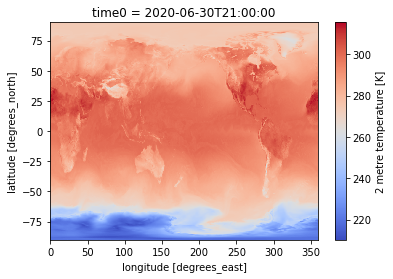

In [22]:
%%time 
dset['air_temperature_at_2_metres'].sel(time0='2020-06-30T21:00').plot(cmap = 'coolwarm')

### Save intermediate results to local disk

In [23]:
%%time
dset['air_temperature_at_2_metres'].sel(time0='2020-06-30T21:00').to_netcdf("ERA5_air_temperature_at_2_metres_2020-06-30T2100.nc")

CPU times: total: 8.02 s
Wall time: 4.59 s


### Open local file before plotting

In [24]:
dset = xr.open_dataset("ERA5_air_temperature_at_2_metres_2020-06-30T2100.nc")

CPU times: total: 203 ms
Wall time: 217 ms


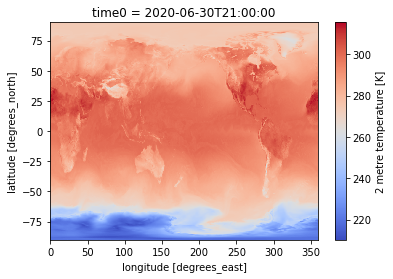

In [25]:
%%time 
dset['air_temperature_at_2_metres'].plot(cmap = 'coolwarm')
#same plot with local file


## Customize plot

Set the size of the figure and add coastlines

CPU times: total: 4.84 s
Wall time: 4.93 s


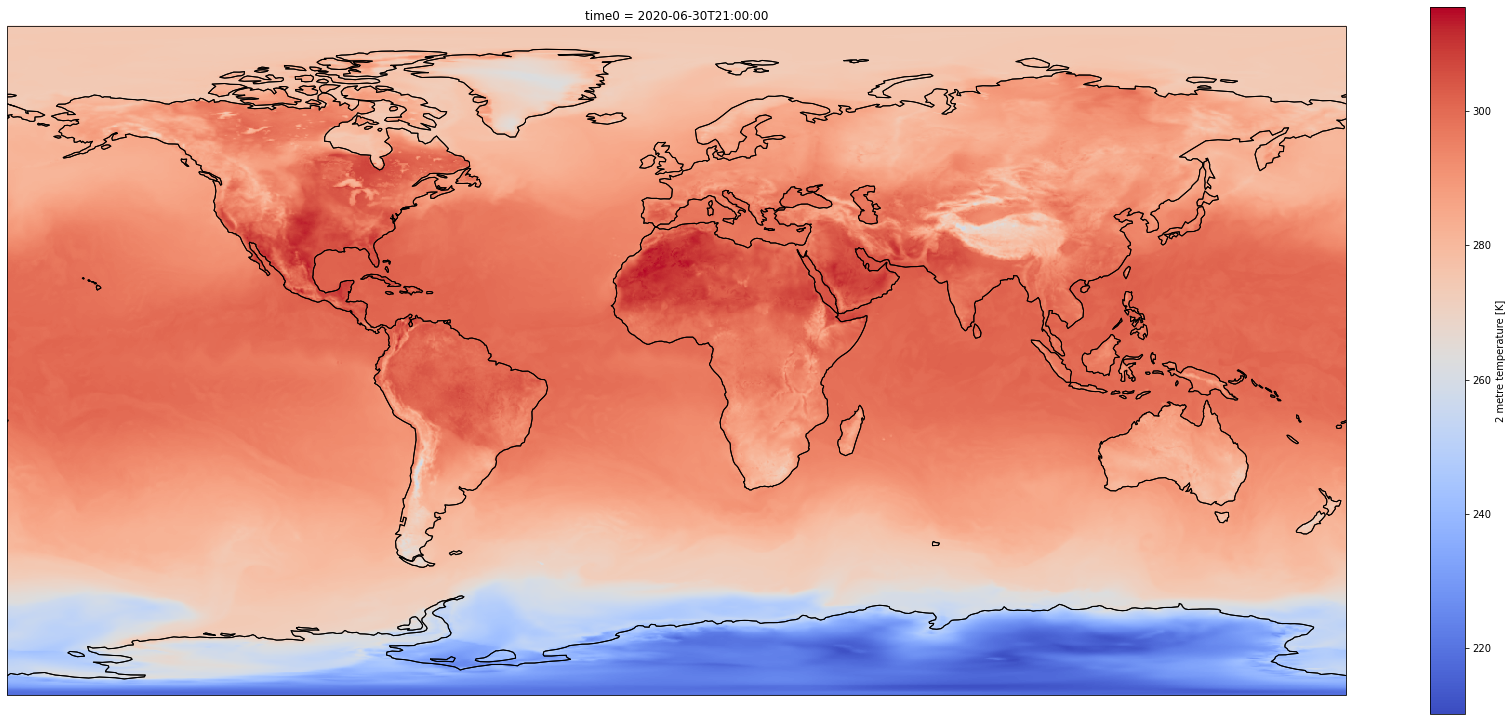

In [26]:
%%time
fig = plt.figure(1, figsize=[30,13])

# Set the projection to use for plotting
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ay = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ay.coastlines()
# Pass ax as an argument when plotting. Here we assume data is in the same coordinate reference system than the projection chosen for plotting
# isel allows to select by indices instead of the time values
dset['air_temperature_at_2_metres'].plot.pcolormesh(ax=ax,cmap='coolwarm')

CPU times: total: 1.41 s
Wall time: 1.41 s


Text(0.5, 1.0, 'ERA5 air temperature at 2 metres\n 30th June 2020 at 21:00 UTC')

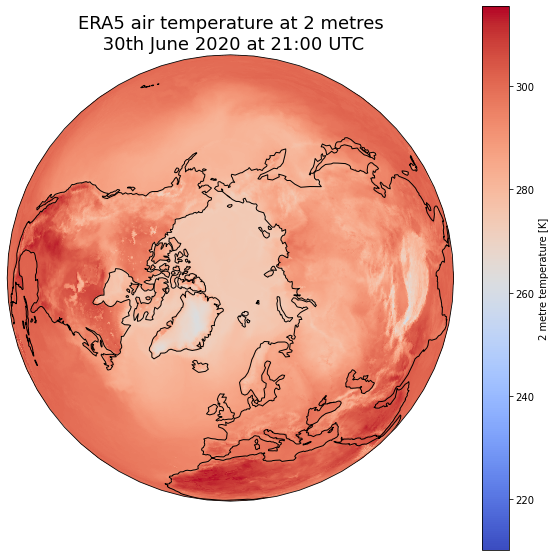

In [27]:
%%time

fig = plt.figure(1, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
dset['air_temperature_at_2_metres'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
plt.title("ERA5 air temperature at 2 metres\n 30th June 2020 at 21:00 UTC", fontsize=18)

CPU times: total: 1.84 s
Wall time: 1.87 s


Text(0.5, 1.0, 'ERA5 air temperature at 2 metres\n 30th June 2020 at 21:00 UTC')

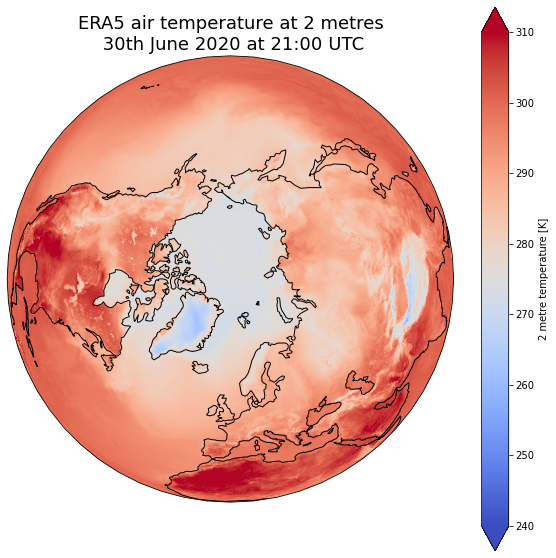

In [28]:
%%time
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# Fix extent
minval = 240
maxval = 310

# pass extent with vmin and vmax parameters
dset['air_temperature_at_2_metres'].plot(ax=ax, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
plt.title("ERA5 air temperature at 2 metres\n 30th June 2020 at 21:00 UTC", fontsize=18)

## Combine plots with different projections

CPU times: total: 3.22 s
Wall time: 3.23 s


Text(0, 0.5, 'K')

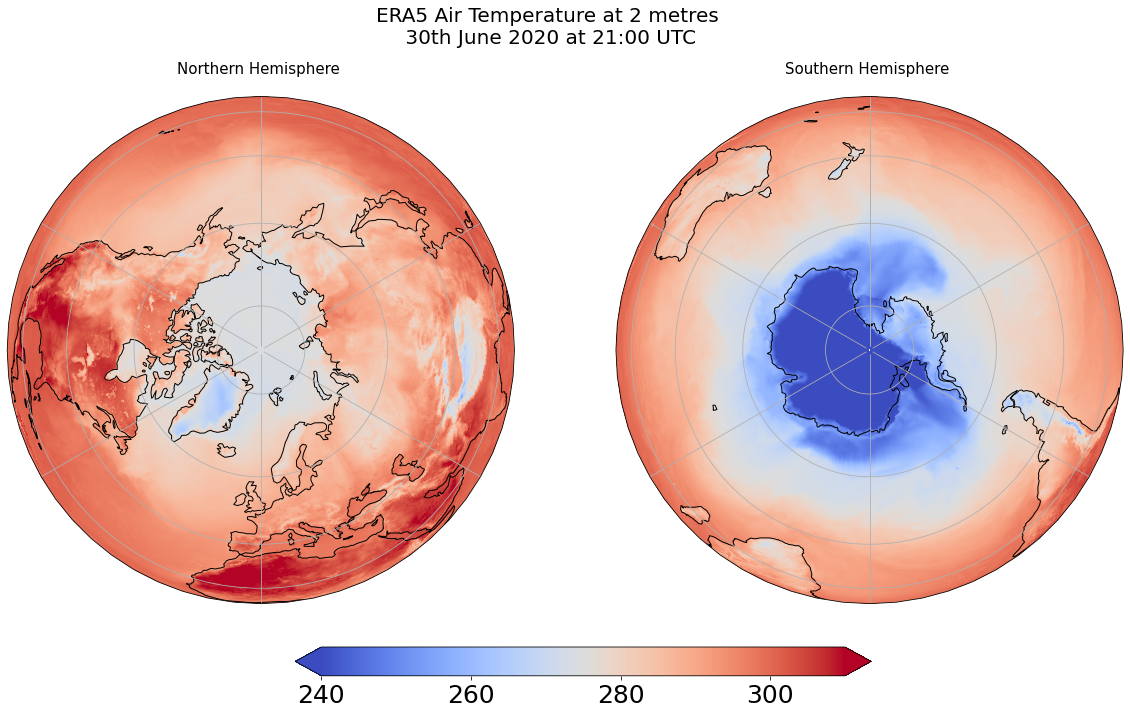

In [29]:
%%time
fig = plt.figure(1, figsize=[20,10])

# Fix extent
minval = 240
maxval = 310

# Plot 1 for Northern Hemisphere subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

# Plot 2 for Southern Hemisphere
# 2nd plot 
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(180, -90))

tsel = 0
for ax,t in zip([ax1, ax2], ["Northern", "Southern"]):
    map = dset['air_temperature_at_2_metres'].plot(ax=ax, vmin=minval, vmax=maxval, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)
    ax.set_title(t + " Hemisphere \n" , fontsize=15)
    ax.coastlines()
    ax.gridlines()

# Title for both plots
fig.suptitle('ERA5 Air Temperature at 2 metres\n 30th June 2020 at 21:00 UTC', fontsize=20)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_ylabel('K', fontsize=25)

Note

This is an example notebook to introduce you to the functions. 
Try to run the same with your project data.

1. Open your data file
2. Get metadata
3. Get your required variable
4. Create a simple visualization using xarray plotting method
5. Save your intermediate results to local disk
6. Plot with your local file
7. Customize your plots
    - Change plotting projection
    - Choose extent of values
    - Combine plots with different projections



